# 关于YOLO

- YOLO的全名是
    - You Only Look Once. 
- YOLO v3的目标检测器，这是目前最快的目标检测算法之一。


- 深度学习的发展给目标检测任务带来了显著提升。近年来人们开发了许多用于目标检测的算法，包括
    - YOLO
    - SSD
    - Mask RCNN
    - RetinaNet
    - 。。。

- 官方提供的网络结构
    - cfg配置文件
    - 下载路径：`https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg`
    
- 备注：
    - 官方提供的代码是caffe的，网络定义在.protxt里面


- 下载别人训练好的模型：
    - `https://pjreddie.com/media/files/yolov3.weights`

- 资源参考：
    - `https://pjreddie.com/`
    - `https://github.com/pjreddie/darknet`
    - E文：`https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/`
    - C文：`https://www.cnblogs.com/Thinker-pcw/p/10895094.html`

# 解析cfg文件

- YOLO网络结构采用配置文件管理，可以读取配置文件，实现网络结构构建。

## 配置文件格式

- 配置文件比较大，一共789行，按照节组织。
    - 每节开头：`[节类型]`
    - 其余都是配置信息

```python
    [net]
    # Testing
    # batch=1
    # subdivisions=1
    # Training
    batch=64
    subdivisions=16
    width=608
    height=608
    channels=3
    momentum=0.9
    decay=0.0005
    angle=0
    saturation = 1.5
    exposure = 1.5
    hue=.1

    learning_rate=0.001
    burn_in=1000
    max_batches = 500200
    policy=steps
    steps=400000,450000
    scales=.1,.1

    [convolutional]
    batch_normalize=1
    filters=32
    size=3
    stride=1
    pad=1
    activation=leaky
```

## YOLO工作原理

### 原理说明

#### YOLO的网络结构特点

1. YOLO是一个全卷积网络(FCN)，只使用了卷积层。
2. YOLO包含75个卷积层，以及跳层连接和上采样层。
    - YOLO没有使用池化降维，而是使用一个步长为2的卷积层对特征图进行降采样来防止池化造成的特征丢失。
3. YOLO作为一个FCN，本身不受输入图像大小的影响。
    - 实际上，在实践中图像还是采用固定大小的输入尺寸。
4. YOLO的采样特点
    - YOLO网络通过卷积的步长对图像进行下采样。
        - 例如，如果网络的步长为32，那么大小为416 x 416的输入图像将产生大小为13 x 13的输出。

#### 网络输出

1. 在YOLO中，预测是通过使用1 x 1的卷积层来完成的。
    - 通常卷积层学习到的特征被送到最后的分类器/回归器上，分类器/回归器进行检测预测(边界框的坐标、类标签)。
- 注意：
    - YOLO的输出是一个feature map。因为我们使用了1 x 1卷积，所以预测图的大小与之前的特征图的大小完全相同。
    - 在YOLO v3中，feature map的每个单元格可以预测固定数量的边界框。
    - 虽然描述特征图中的一个单元的正确术语应该是神经元，但在下文中，称它为细胞使它更直观。

2. **feature map**
    - feature map中有 (B x (5 + C)) 维。
        1. B表示每个单元格可以预测的边界框数。根据论文，B个边界框中的每一个可以都可以检测某个特殊物品。
        2. 每个边界框都有5 + C 个属性，这些属性用于描述每个边界框的**【中心坐标】**、【长宽】、【目标得分】和C个物品【类别置信度】。
        3. YOLO v3中每个细胞预测3个标注框,也就是B=3。
        

4. **预测边框**
    - 如果目标的中心落在某个细胞的接受域内，则期望这个细胞通过它其中一个预测的边界框来预测对象。
    - 这一设置这与YOLO的训练方式有关，也就是只有一个边界框负责检测给定的对象。为了做到这点，首先我们必须确定这个边界框属于哪个cell。
    - 为此，我们将输入图像划分为与最终feature map相同维度的网格。

5. **图像网格与feature map关系理解**
    - 如下输入图像是416 x 416，网络的步长是32。如前所述，feature map的尺寸为13 x 13。然后我们将输入图像分成13个x 13个单元格。
    - 然后，选择包含对象真值边界框中心的单元格(在输入图像上)作为负责预测对象的单元格。
        - 下图中标记为红色的单元格包含ground truth框的中心(标记为黄色)。
        - 红色的细胞是网格上第7行第7个细胞。我们便将feature map的第7行中的第7个细胞 (feature map上对应的cell) 指定为负责检测狗的cell。

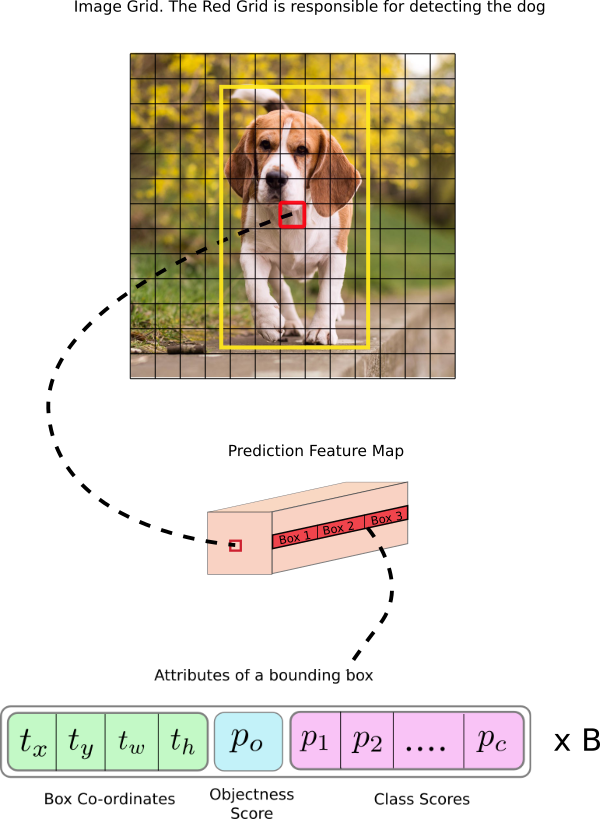

6. **锚盒**
    - 问题：论文中提及YOLO每个cell可以预测三个边界框。哪一个才是对应了狗的呢?
        - 在实践中，YOLO不会预测边界框的宽度和高度因为这会导致训练的不稳定，现阶段大多数目标检测器都是预测一个对数空间的转换。之后将这些转换加到锚点上来获得锚盒作为预测结果。
        - YOLO v3有三个锚盒，也就对应了每个cell预测的三个边界框。回到我们之前的问题上，负责检测狗的cell中的那个锚盒是与真实框中IoU最高的那个。
            - IoU：交并比（Intersection-over-Union，IoU）：是产生的候选框（candidate bound）与原标记框（ground truth bound）的交叠率
即它们的交集与并集的比值。最理想情况是完全重叠，即比值为1。

#### 预测

- 下面的公式描述了如何转换网络输出以获得边界框预测（最后两个公式就是前面提到的对数空间转换）。
    - $b_x = \sigma(t_x) + c_x$
    - $b_y = \sigma(t_y) + c_y$
    - $b_w = p_w e ^ {t_w}$
    - $b_h = p_h e ^ {t_h}$
- 上式中$b_x, b_y, b_w, b_h$分别对应预测的中心坐标，宽度和高度。$t_x, t_y, t_w, t_h$是网络输出的值。$c_x$和$c_y$是网格的左上坐标。$p_w$和$p_h$是盒子的锚盒尺寸。下面对上式的含义以及$c_x,c_y,p_w,p_h$进行说明

1. **中心坐标**
    - 我们通过一个sigmoid函数进行中心坐标预测，这是因为sigmoid能够迫使输出的值在0和1之间。可以看到YOLO没有预测边界框中心的绝对坐标，它预测的相对于检测目标的cell的左上角坐标$(c_x,c_y)$的偏移量，这一偏移量通过cell的尺寸大小标准化。
    - 还是以上图狗为例。如果中心坐标的预测值为(0.4,0.7)，则意味着实际中心位于13 x 13 feature map上的 (6.4,6.7) 。(因为红色cell的左上坐标是(6,6))。
    - 如果预测的xy坐标大于1会发生什么？比如(1.2,0.7)，这意味着中心在 (7.2,6.7) 处，那就到了第7行第8个cell。其实这是不可能的，因为如果我们假设红色cell负责预测狗，狗的中心就必须位于红色的cell中，这是yolo的规定。

2. **边界框尺寸**
    - 将预测的长宽$t_w,t_h$经过对数空间变换，再与锚盒长宽$(p_w,p_h)$相乘来预测边界框的大小。
    - $bw$和$bh$也像$cx,cy$一样经过了标准化。因此包含狗的检测框的预测$bw$和$bh$为$(0.3,0.8)$，那么在$13 \times 13$ feature map上的实际宽度和高度为$(13 \times 0.3, 13 \times 0.8)$。

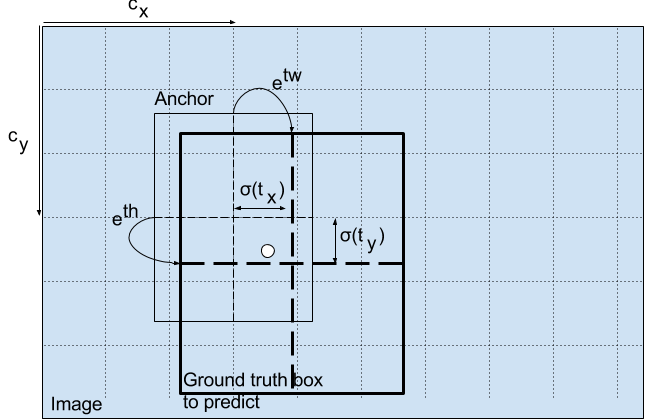

3. **目标得分**
    - 目标得分表示边界框包含目标的概率。对于红色和相邻的网格应该接近1，而对于角上的网格，应该接近0。
    - 目标得分也经过sigmoid函数转换为一个概率。

4. **类别置信度**
    - 类别置信度表示被检测对象属于特定类(狗、猫、香蕉、汽车等)的概率。在v3之前，YOLO使用softmax计算类别置信度。
    - 然而作者在v3中选择使用sigmoid，原因是softmax假定类是互斥的。简单地说，如果一个对象属于一个类，那么它就不能属于另一个类。
    - 这对于COCO数据库是正确的，但是当我们有像女人和人这样的类别时，这种假设可能就不成立了。这是作者避免使用Softmax激活的原因。

5. **不同尺度的预测**
    - YOLO v3在三个不同的尺度上进行预测。检测层会对三种不同尺寸的特征图进行检测，它们的步长分别为32步、16步和8步。这意味着，在输入维度为416 x 416的情况下，我们会在13 x 13、26 x 26和52 x 52这几个尺寸上进行检测。
    - 网络将输入图像下采样至第一个检测层，使用步长为32的层的特征图进行检测。之后将层向上采样2倍，并与具有相同特征映射大小的前一层特征映射连接起来，在这一步长为16的层上使用另一个检测器。重复同样的上采样过程，最后在步长为8的层进行检测。
    - 在每个尺度上，每个cell使用3个锚盒预测3个边界框，所以每个cell的锚盒总数为9。
    - 作者说这有助于YOLO v3更好地检测小目标，小目标丢失是早期版本YOLO经常遇到的问题。上采样可以帮助网络学习细粒度的特征，这些特征对于检测小对象非常有用。

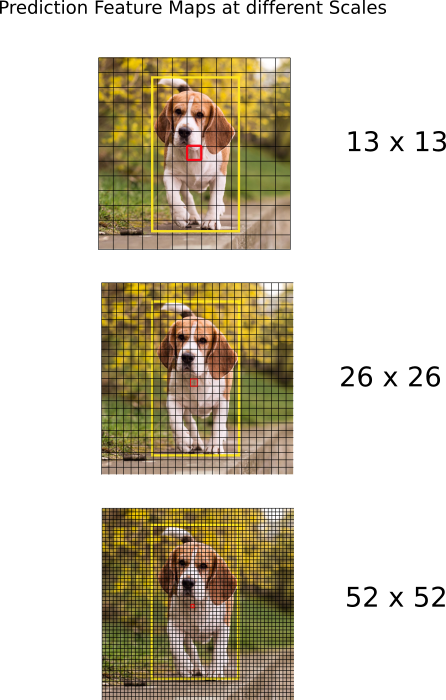

6. **输出处理**
    - 对于大小为416 x 416的图像，YOLO预测了 ((52 x 52) + (26 x 26) + 13 x 13) x 3 = 10647 个边界框。然而我们的图像中只有一个目标就是一条狗。如何将检测从10647减少到1?

7. **目标置信度阈值**
    - 首先，我们根据边界框的得分对它们进行筛选。得分低于阈值的框将被忽略。

8. **非极大值抑制（NMS）**
    - NMS旨在解决同一幅图像的多重检测问题。例如，红色cell的3个边界框都可能检测到一个框，或者相邻的cell也可能检测到相同的目标。

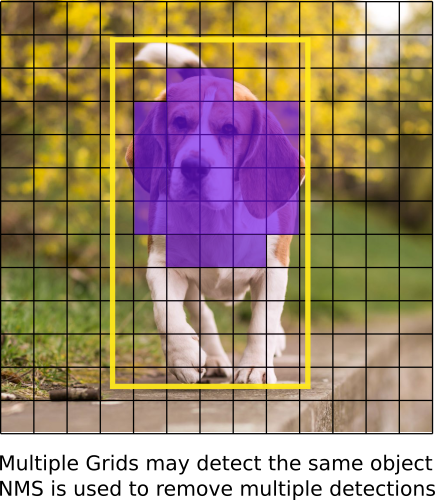

## 配置文件说明

- YOLO只能检测属于训练网络的数据集中存在类别的目标。我们将使用官方的权重文件作为我们的检测器。这些权值通过在COCO数据集上进行训练得到，所以可以检测到80个目标类别。

### YOLO检测层

1. 格式例子

``` python
    [yolo]
    mask = 0,1,2
    anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
    classes=80
    num=9
    jitter=.3
    ignore_thresh = .7
    truth_thresh = 1
    random=1
```

2. 格式说明：
    - YOLO层就对应着检测层。
    - anchors属性定义了9个锚，但是只会使用mask属性指定索引位置处的那些锚。
        - 这里mask的值为0,1,2就代表第一个，第二个和第三个锚被使用。
        - 这是有道理的，因为每个检测层的每个cell会预测三个边界框。我们有三种不同尺寸的锚，所以总共会有9个锚盒。
    - 我们使用的这个网络结构有三个YOLO检测层，分别使用0，1，2 **/** 3, 4, 5 **/** 6, 7, 8

###  net结构超参数描述

1. 格式例子

```python
    [net]
    # Testing
    # batch=1
    # subdivisions=1
    # Training
    batch=64
    subdivisions=16
    width=608
    height=608
    channels=3
    momentum=0.9
    decay=0.0005
    angle=0
    saturation = 1.5
    exposure = 1.5
    hue=.1

    learning_rate=0.001
    burn_in=1000
    max_batches = 500200
    policy=steps
    steps=400000,450000
    scales=.1,.1
```

2. 格式说明
    - 这是cfg中的一种block类型叫做net，但是我们不把他当作一个层，因为它只描述了网络的输入和训练参数的信息。在YOLO的前向传播过程中不会用到。但是它提供给我们网络输入尺寸的信息，我们用它来调整前向传播过程中的锚。

### Convolutional卷积层

1. 格式例子

```python
    [convolutional]
    batch_normalize=1
    filters=32
    size=3
    stride=1
    pad=1
    activation=leaky
```

2. 格式说明
    - batch_normalize：做BN处理，这个在网络深度比较大的情况，用来防止网络梯度爆照。
    - filters：输出深度（卷积核个数）
    - size：卷积核大小
    - stride：b补偿
    - pad：补边
    - activation：激活函数

### Shortcut层

1. 格式例子

```python
    [shortcut]
    from=-3
    activation=linear
```

2. 格式说明：
    - 这里有个from参数为-3，它代表shortcut层的输出是将前一层输出与后面第三层的特征图加起来得到的。

### Upsample层

1. 格式例子

```python
    [upsample]
    stride=2
```

2. 格式说明：
    - 用双线性上采样，以因子stride对上一层的特征图进行上采样。

### Route层

1. 格式例子

```python
    [route]
    layers = -4

    [route]
    layers = -1, 61
```

2. 格式说明：
    - Route有一个属性layers,可以是一个值也可以是两个值
        1. 当layers属性只有一个值的时候，它输出的是索引处的特征图。
            - 在上面例子中，它是-4就代表输出的特征图将来自于Route层前的第4层
        2. 当layers属性有两个值时，它返回的是按照索引值连接起来的特征图。
            - 在上面例子中为-1，61就代表输出的特征图来自Route层前一层（-1）和第61层在深度维度上的拼接。
    - 注意：
        - 上面的正负表示参照点：
            - 负从route位置作为参照点；
            - 正从1开始作为参照点。

## 配置文件读取实现

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
# from torch.autograd import Variable
import numpy as np
import cv2

def parse_cfg(cfgfile):
    """
    Takes a configuration file
    Returns a list of blocks. Each blocks describes a block in the neural
    network to be built. Block is represented as a dictionary in the list

    """
    file = open(cfgfile, 'r')
    lines = file.read().split('\n')    # store the lines in a list
    lines = [x for x in lines if len(x) > 0] # get read of the empty lines 
    lines = [x for x in lines if x[0] != '#'] # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    block = {}
    blocks = []

    for line in lines:
        if line[0] == "[":               # This marks the start of a new block
            if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-init the block
            block["type"] = line[1:-1].rstrip()     
        else:
            key,value = line.split("=") 
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)

    return blocks


In [2]:
# 测试
# blocks = parse_cfg("yolov3.cfg")
# print(len(blocks))

------

# 使用配置创建Modules

- 由于卷积层在PyTorch中有实现，但是YOLO与Shortcut层没有实现，所以这里先实现；
    - Shortcut层本身是空层。
    - YOLO层主要是锚盒。

## Shortcut层实现

In [3]:
class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()

## YOLO检测层实现

- 这儿只是用Module来保存层的数据。

In [4]:
class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        # 保存锚点
        self.anchors = anchors

## 从配置文件构建网络模型

In [5]:
def create_modules(blocks):
    net_info = blocks[0]   # 获取net块，输入与与预处理参数    
    module_list = nn.ModuleList()  # 存储构建的模块
    prev_filters = 3     # 
    output_filters = []
    for index, x in enumerate(blocks[1:]):   # 从第二个块开始，索引为1。
        module = nn.Sequential()
        
        # 根据不同的块构建不同的层。层保存在module_list
        if (x["type"] == "convolutional"):  # 卷积层
            # 读取构建卷积层的参数
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True

            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])

            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0
            
            # 构建卷积层
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)

            # 对卷积层做BN数据处理
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)

            # 激活函数处理，默认是y = x 激活函数 
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)
        
        # 上采样层
        elif (x["type"] == "upsample"):         #上采样
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners=False)   # 双线性插值采样
            module.add_module("upsample_{}".format(index), upsample)
        # Router层
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            # 获取route的两个值，也可能是一个，就采用默认值0
            start = int(x["layers"][0])
            # end值，不存在就取0.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            # 为正的处理方式
            if start > 0: 
                start = start - index    # index是blocks的当前索引，从1开始的。
            if end > 0:
                end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            # 为负的处理方式
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]

        # shortcut层
        elif x["type"] == "shortcut":                 # shortcut
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
            
        # Yolo侦测层
        elif x["type"] == "yolo":                     # yolo
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]

            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]

            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)
        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)
    return (net_info, module_list)


In [6]:
# net, modules = create_modules(blocks)
# print(net)
# print(modules)

# 构建Darknet

- 这个类就是网络类：
    - 1. forawrd计算
    - 2. 因为我们不想从头计算，先加载别人训练好的权重，所以增加了一个loadWeight成员函数。

## 工具函数 - 预测结果转换 

In [7]:

def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):

    
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])
    
    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors
    
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride
    
    return prediction


## Darknet网络

In [8]:
class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)    # 调用前面的实现，加载cfg文件。
        self.net_info, self.module_list = create_modules(self.blocks)    # 根据cfg文件，创建YOLO的模块层。
        
    def forward(self, x, CUDA):   # CUDA是bool值
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        
        write = 0
        for i, module in enumerate(modules):        
            module_type = (module["type"])
            
            if module_type == "convolutional" or module_type == "upsample":   # 计算卷积层与上采样层
                x = self.module_list[i](x)
    
            elif module_type == "route":      # route层开始合并x
                layers = module["layers"]
                layers = [int(a) for a in layers]
    
                if (layers[0]) > 0:
                    layers[0] = layers[0] - i
    
                if len(layers) == 1:
                    x = outputs[i + (layers[0])]
    
                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i
    
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)
                
    
            elif  module_type == "shortcut":    # 
                from_ = int(module["from"])
                x = outputs[i-1] + outputs[i+from_]   # 数据集合并
    
            elif module_type == 'yolo':        # 检测计算
                anchors = self.module_list[i][0].anchors
                # 输入的维数
                inp_dim = int (self.net_info["height"])
        
                # 分类数量
                num_classes = int (module["classes"])
        
                #Transform 
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)   # 预测结果转换，CUDA表示使用cuda计算。
                if not write:              #if no collector has been intialised. 
                    detections = x
                    write = 1
        
                else:       
                    detections = torch.cat((detections, x), 1)
        
            outputs[i] = x
        
        return detections


    def load_weights(self, weightfile):
        # 打开训练的权重文件
        fp = open(weightfile, "rb")
    
        # 前面5个值是信息头。
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4,5. Images seen by the network (during training)
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]   
        
        weights = np.fromfile(fp, dtype = np.float32)
        
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
    
            #If module_type is convolutional load weights
            #Otherwise ignore.
            
            if module_type == "convolutional":   # 只有卷积才有权重，其他的都没有。
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
            
                conv = model[0]
                
                
                if (batch_normalize):
                    bn = model[1]
        
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
        
                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
        
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
        
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)
        
                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights
                
                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)


## 测试网络

### 图像的大小处理

#### 把图像缩放到网络要求的大小。

In [9]:
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

#### 把图像格式转换为网络需要的格式。

In [10]:
def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """
    img = (letterbox_image(img, (inp_dim, inp_dim)))
    img = img[:,:,::-1].transpose((2,0,1)).copy()
    img = torch.from_numpy(img).float().div(255.0).unsqueeze(0)
    return img


### 加载图片

In [11]:
img = cv2.imread("dog-cycle-car.png")

### 构建网络并测试没有训练过的网络

In [12]:
model = Darknet("yolov3.cfg")
img= prep_image(img, int(model.net_info["height"]))           # 图片一定要与网络中设置的大小一致，也可以自己修改网络中图片大小，只要一致即可。
pred = model(img, False)
print (pred.shape)
print (pred)

torch.Size([1, 22743, 85])
tensor([[[1.7491e+01, 1.7158e+01, 1.8115e+02,  ..., 4.8288e-01,
          4.9220e-01, 4.8446e-01],
         [1.8524e+01, 1.7723e+01, 1.3730e+02,  ..., 5.8636e-01,
          5.7236e-01, 5.6645e-01],
         [1.8496e+01, 1.6197e+01, 4.2011e+02,  ..., 5.3085e-01,
          4.6182e-01, 4.5247e-01],
         ...,
         [6.0394e+02, 6.0445e+02, 1.3154e+01,  ..., 5.0594e-01,
          5.3606e-01, 5.8802e-01],
         [6.0391e+02, 6.0403e+02, 1.8627e+01,  ..., 4.8578e-01,
          4.5797e-01, 4.6027e-01],
         [6.0366e+02, 6.0409e+02, 3.8269e+01,  ..., 4.9653e-01,
          5.0232e-01, 5.7505e-01]]])


### 图片处理的说明

- 输入图片只要保持三个要素：
    - 维度格式一致。
    - 大小一致
    - 必须是Tensor类型

- 注意：
    - 其中letterbox_image是的图像按照比例缩放，并在周围补边（padding）。
    - 如果想直接缩放，则使用如下方式即可。

In [13]:
def get_test_input():
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (416,416))          #Resize to the input dimension
    img_ =  img[:,:,::-1].transpose((2,0,1))  # BGR -> RGB | H X W C -> C X H X W 
    img_ = img_[np.newaxis,:,:,:]/255.0       #Add a channel at 0 (for batch) | Normalise
    img_ = torch.from_numpy(img_).float()     #Convert to float
    # img_ = Variable(img_)                     # Convert to Variable # 这是老版本的风格，新版本使用不再需要。
    return img_


### 预测输出说明

- 输出tensor的维度为1\*22743\*85。
    1. 第一维是批大小，因为我们只有一张图片所以是1。
    2. 第二维代表边框，一共 22743个候选变量；
    3. 每个边框的数据：前面5个是中心位置，大小，置信度，后面80个是这个边框属于每一类的概率。
        - 表格的每一行代表了一个边界框（4个bbox属性，1个目标置信度，80个类得分）。

## 使用已经训练好的权重

- 直接使用loadWeight函数加载即可。然后再预测，就可以得到比较精确的结果。

In [14]:
# 创建模型
model = Darknet("yolov3.cfg")

# 加载并预处理图像
img = cv2.imread("dog-cycle-car.png")
img= prep_image(img, int(model.net_info["height"]))       

# 加载权重
model.load_weights("yolov3.weights")

# 模型预测
pred = model(img, False)

# 输出预测值
print (pred.shape)
print (pred)

torch.Size([1, 22743, 85])
tensor([[[1.7859e+01, 8.6451e+00, 9.0740e+01,  ..., 1.4895e-05,
          2.3574e-05, 9.4851e-06],
         [2.0096e+01, 1.4215e+01, 9.7096e+01,  ..., 9.9291e-07,
          1.2501e-05, 2.0968e-05],
         [2.2790e+01, 8.3181e+00, 4.4848e+02,  ..., 1.2315e-04,
          2.0767e-04, 8.8497e-05],
         ...,
         [6.0405e+02, 6.0309e+02, 3.3433e+00,  ..., 8.1887e-07,
          3.4106e-06, 1.0439e-06],
         [6.0286e+02, 6.0236e+02, 8.0452e+00,  ..., 6.0839e-06,
          2.7558e-05, 1.2609e-05],
         [6.0304e+02, 6.0481e+02, 4.4321e+01,  ..., 1.7480e-06,
          1.0261e-05, 9.4611e-06]]])


# 获得预测结果

- 上面获取的预测结果需要处理后才能获得真正的检测结果，需要两个处理。
    1. 目标置信度阈值（扔掉概率低）
    2. 极大值抑制（计算IoU，并取最大值，最大值为1）

## 去重函数实现

In [15]:
def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)
    
    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res


## IoU计算函数实现

In [16]:
def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    
    
    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    
    return iou


## 预测处理实现

In [17]:
def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask
    
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = prediction.size(0)

    write = False
    
    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
       #confidence threshholding 
       #NMS
    
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)
        
        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except:
            continue
        
        if image_pred_.shape[0] == 0:
            continue       
#        
  
        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1])  # -1 index holds the class index
        
        
        for cls in img_classes:
            #perform NMS

        
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)   #Number of detections
            
            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
            
                except IndexError:
                    break
            
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       
            
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
                
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class
            
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    try:
        return output
    except:
        return 0

## 测试预测结果

In [18]:
prediction = write_results(pred, 0.5,  80, 0.4)   # 0.5 最低置信度， 0.4IoU阈值， 80是类别数。
print(prediction.shape)
print(prediction)

torch.Size([3, 8])
tensor([[  0.0000,  88.7280, 181.0206, 457.9579, 422.4691,   0.9975,   0.9996,
           1.0000],
        [  0.0000, 375.5378, 139.4817, 547.6677, 210.5835,   0.9997,   0.8616,
           7.0000],
        [  0.0000, 104.7170, 255.3991, 250.6669, 500.8145,   0.9996,   0.9997,
          16.0000]])


- 输出结果说明：
    1. 检测结果输出一个形状为 Dx8 的tensor。这里D是所有图像的真实检测，每个都用一行表示（这里检测出来是3个）。
    2. 每个检测有8个属性，即检测所属批次图像的索引、4个角坐标、目标置信度得分、最大置信类得分、该类的索引。

## 类别名加载

In [19]:
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

# 加载类别
# 

## 完整的目标侦测的代码

tensor([[  0.0000,  87.8524, 104.2342, 453.4387, 343.3000,   0.9975,   0.9996,
           1.0000],
        [  0.0000, 371.8318,  63.1053, 542.2631, 133.5054,   0.9997,   0.8616,
           7.0000],
        [  0.0000, 103.6836, 177.8787, 248.1932, 420.8722,   0.9996,   0.9997,
          16.0000]])
类别: bicycle
类别: truck
类别: dog


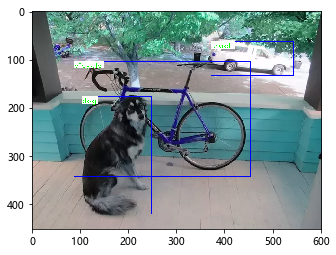

In [20]:

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import cv2 

# from util import *
# from darknet import Darknet
import cv2

CUDA = False

# 1. 构建模型对象
model = Darknet('yolov3.cfg')

# 2. 预训练模型
model.load_weights("yolov3.weights")

# 3. 准备识别的图像
img_src = cv2.imread("dog-cycle-car.png")

def handle_image(model, img_src):
    # model.net_info["height"] = 416
    # 获取识别图像的大小
    inp_dim = int(model.net_info["height"]) 
    # 图像的预处理resize -> format -> normal -> Tensor
    img = prep_image(img_src, inp_dim)

    prediction = model((img), CUDA)
    # print(prediction)
    # print(prediction.shape)
    # 去掉是对象概率低的值，并且去掉相同对象
    prediction = write_results(prediction, 0.5, 80, 0.4)
    # print(prediction)
    # print(prediction.shape)
    # 还原原始图片大小单位位置
    im_dim = [(img_src.shape[1], img_src.shape[0])]    # 图像大小
    im_dim = torch.FloatTensor(im_dim).repeat(1,2)     # 得到重复的大小，行数不改变

    im_dim = torch.index_select(im_dim, 0, prediction[:,0].long())   # 因为有三个框，所以选择产生三个维度
    scaling_factor = torch.min(608/im_dim, 1)[0].view(-1,1)

    prediction[:,[1,3]] -= (inp_dim - scaling_factor*im_dim[:,0].view(-1,1))/2
    prediction[:,[2,4]] -= (inp_dim - scaling_factor*im_dim[:,1].view(-1,1))/2

    prediction[:,1:5] /= scaling_factor

    # 显示候选对象不要在图像外
    for i in range(prediction.shape[0]):
        prediction[i, [1,3]] = torch.clamp(prediction[i, [1,3]], 0.0, im_dim[i,0])   # 把输出现在图像中，不要越过图像
        prediction[i, [2,4]] = torch.clamp(prediction[i, [2,4]], 0.0, im_dim[i,1])

    print(prediction)

    # 显示
    classes = load_classes("coco.names")
    for x in prediction:
        print("类别:", classes[int(x[-1])])
        cls_name = classes[int(x[-1])]
        # 在图像上标记
        c1 = tuple(x[1:3].int())   # 位置
        c2 = tuple(x[3:5].int())   # 大小
        # 绘制矩形
        cv2.rectangle(img_src, c1, c2, (0, 0, 255, 255), 1)
        # 获取文本的边框轮廓
        t_size = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
        # 绘制文本的实心矩形
        c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
        cv2.rectangle(img_src,  c1, c2, (255, 255, 255,255), -1)   # -1填充
        # 绘制文本
        cv2.putText(img_src, cls_name, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 1)
    return img_src

img_src = handle_image(model=model, img_src=img_src)
# 保存图像
# cv2.imwrite("dog.png", img_src)
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img_src) 

-------